In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [3]:
# Import gene matrix, protein matrix, and list of genes for ensembl translation
import anndata as ad
gene_matrix_df = pd.read_csv("https://www.dropbox.com/s/910hhahxsbd9ofs/gene_matrix_all_new.csv?dl=1", header=0, sep=",")
# print(gene_matrix_df)

protein_df = pd.read_csv("https://www.dropbox.com/s/xzobh2p13cqt4y5/protein_expr_all.csv?dl=1", header=0, sep=",")
# print(protein_df)

genes_list_df = pd.read_csv("https://www.dropbox.com/s/11dmp8ki6tui2zu/genes.tsv?dl=1", header=None, sep="\t")
# print(genes_list_df)

# Change first column of protein matrix to not be the index
protein_df.reset_index(inplace=True)
# print(protein_df.iloc[:,0])

In [4]:
# Removing ADT_ prefix from proteins (colname function in R)
import re
def clean_adt(cite_protein_df):
    cite_protein_df_copy = cite_protein_df.copy(deep=True)
    cite_protein_df_copy.iloc[:,0] = cite_protein_df_copy.iloc[:,0].apply(lambda x: re.sub("ADT_", "", x))
    return cite_protein_df_copy

# test = clean_adt(protein_df)
# print(test)

In [5]:
# Convert ensembl names to gene names
def convert_ensembl(gene_matrix_df, genes_list_df):
    # Copy of gene matrix
    gene_matrix_df_copy = gene_matrix_df.copy(deep=True)
    
    # Transpose
    gene_matrix_df_copy_transposed = gene_matrix_df_copy.T
    
    # Create dictionary from gene list for translating ensembl names
    genes_list_dict = dict(zip(genes_list_df[0], genes_list_df[1]))
    
    # Return a new matrix
    translated_matrix = gene_matrix_df_copy_transposed.rename(columns = lambda x: genes_list_dict.get(x))
    return translated_matrix

In [6]:
# Translate ensembl names
converted_matrix = convert_ensembl(gene_matrix_df, genes_list_df)
print(converted_matrix)

                       Mrpl15  Lypla1  Tcea1  Atp6v1h  Rb1cc1  4732440D04Rik  \
m1_AAACCTGAGAGCAATT.1       0       0      0        0       0              0   
m1_AAACCTGCAAGCTGTT.1       0       0      0        0       0              0   
m1_AAACCTGCAGGATCGA.1       0       0      0        1       1              1   
m1_AAACCTGCATCCAACA.1       0       0      0        0       0              0   
m1_AAACCTGTCAGTCCCT.1       1       0      1        0       0              0   
...                       ...     ...    ...      ...     ...            ...   
m2_TTTGTCAGTTGGAGGT.1       1       0      0        0       0              0   
m2_TTTGTCAGTTTGTTTC.1       0       0      1        1       0              0   
m2_TTTGTCATCAACTCTT.1       0       0      1        0       1              0   
m2_TTTGTCATCACGACTA.1       0       0      0        0       0              0   
m2_TTTGTCATCGTGGACC.1       1       1      1        1       0              0   

                       Pcmtd1  Gm26901 

In [7]:
# Find number of genes per sample 
num_genes = converted_matrix.sum(axis = 1)
print(num_genes)

m1_AAACCTGAGAGCAATT.1    2457
m1_AAACCTGCAAGCTGTT.1    1497
m1_AAACCTGCAGGATCGA.1    8026
m1_AAACCTGCATCCAACA.1    1332
m1_AAACCTGTCAGTCCCT.1    3883
                         ... 
m2_TTTGTCAGTTGGAGGT.1    1580
m2_TTTGTCAGTTTGTTTC.1    2908
m2_TTTGTCATCAACTCTT.1    3701
m2_TTTGTCATCACGACTA.1    1320
m2_TTTGTCATCGTGGACC.1    3656
Length: 7097, dtype: int64


In [8]:
percent_mito = pd.DataFrame(converted_matrix.iloc[:,0])
percent_mito.rename(columns={ percent_mito.columns[0]: "percent mito" }, inplace=True)
percent_mito['percent mito'] = 0
print(percent_mito)

                       percent mito
m1_AAACCTGAGAGCAATT.1             0
m1_AAACCTGCAAGCTGTT.1             0
m1_AAACCTGCAGGATCGA.1             0
m1_AAACCTGCATCCAACA.1             0
m1_AAACCTGTCAGTCCCT.1             0
...                             ...
m2_TTTGTCAGTTGGAGGT.1             0
m2_TTTGTCAGTTTGTTTC.1             0
m2_TTTGTCATCAACTCTT.1             0
m2_TTTGTCATCACGACTA.1             0
m2_TTTGTCATCGTGGACC.1             0

[7097 rows x 1 columns]


In [9]:
# Create anndata object


# Set observations x variables data matrix (the dimensions)
adata = ad.AnnData(converted_matrix, dtype="int64")
# print(adata)

# Add gene matrix to obsm (observation/variable level matrices) used for umap embedding
adata.obsm["gene_expression"] = converted_matrix
# print(adata)

# Add n_genes to obs
adata.obs["n_genes"] = num_genes

# Add percent mito to obs
adata.obs["percent_mito"] = percent_mito

# print(adata)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
adata

AnnData object with n_obs × n_vars = 7097 × 11713
    obs: 'n_genes', 'percent_mito'
    obsm: 'gene_expression'

In [11]:
#adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 32 cells that have less than 200 genes expressed


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
adata.obs

,n_genes,percent_mito
m1_AAACCTGAGAGCAATT.1,1018,0
m1_AAACCTGCAAGCTGTT.1,695,0
m1_AAACCTGCAGGATCGA.1,2347,0
m1_AAACCTGCATCCAACA.1,711,0
m1_AAACCTGTCAGTCCCT.1,1539,0
...,...,...
m2_TTTGTCAGTTGGAGGT.1,777,0
m2_TTTGTCAGTTTGTTTC.1,1072,0
m2_TTTGTCATCAACTCTT.1,1468,0
m2_TTTGTCATCACGACTA.1,703,0


In [13]:
# Continue building adata
adata.layers["counts"] = adata.X.copy()

# Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)
AnnData object with n_obs × n_vars = 7065 × 11713
    obs: 'n_genes', 'percent_mito'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'gene_expression'
    layers: 'counts'


In [14]:
adata

AnnData object with n_obs × n_vars = 7065 × 11713
    obs: 'n_genes', 'percent_mito'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'gene_expression'
    layers: 'counts'

In [15]:
# Feature selection
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    flavor="seurat_v3",
    batch_key=None, 
    subset=True,
    layer="counts"
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [16]:
adata

AnnData object with n_obs × n_vars = 7065 × 2000
    obs: 'n_genes', 'percent_mito'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'gene_expression'
    layers: 'counts'

In [17]:
scvi.model.TOTALVI.setup_anndata(
    adata, 
    protein_expression_obsm_key="gene_expression",
    layer="counts",
    batch_key=None
)

INFO     Using column names from columns of adata.obsm['gene_expression']                                          


In [18]:
# Prepare and run model
vae = scvi.model.TOTALVI(adata, latent_distribution="normal")

INFO     Computing empirical prior initialization for protein background.                                          


In [19]:
vae

TotalVI Model with the following params: 
n_latent: 20, gene_dispersion: gene, protein_dispersion: protein, gene_likelihood: nb, latent_distribution: normal
Training status: Not Trained

In [20]:
vae.train()

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/400:   0%|                                                                 | 0/400 [00:13<?, ?it/s]

ValueError: Expected parameter scale (Tensor of shape (256, 11713)) of distribution Normal(loc: torch.Size([256, 11713]), scale: torch.Size([256, 11713])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[2.3659e-07, 1.5693e-07, 6.9391e-08,  ..., 3.9330e-06, 1.8123e-06,
         3.0314e-07],
        [2.0597e-07, 1.3523e-07, 5.6655e-08,  ..., 3.5091e-06, 1.5842e-06,
         2.6683e-07],
        [3.1582e-06, 2.2449e-06, 1.0856e-06,  ..., 3.2543e-05, 1.7313e-05,
         3.9327e-06],
        ...,
        [1.9159e-07, 1.2747e-07, 5.4566e-08,  ..., 3.3325e-06, 1.4967e-06,
         2.4856e-07],
        [6.7460e-11, 3.8783e-11, 1.0669e-11,  ..., 5.3108e-09, 1.6228e-09,
         1.1132e-10],
        [3.9642e-07, 2.6503e-07, 1.1836e-07,  ..., 5.9629e-06, 2.8401e-06,
         5.0499e-07]])

In [52]:
vae

TotalVI Model with the following params: 
n_latent: 20, gene_dispersion: gene, protein_dispersion: protein, gene_likelihood: nb, latent_distribution: normal
Training status: Trained

In [61]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25,
    return_mean=True,
    transform_batch=[None]
)

adata.layers["denoised_rna"], adata.obsm["denoised_gene"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25,
    return_mean=True,
    transform_batch=[None]
)
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["gene_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

In [63]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_totalVI', the cluster labels (adata.obs, categorical) (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


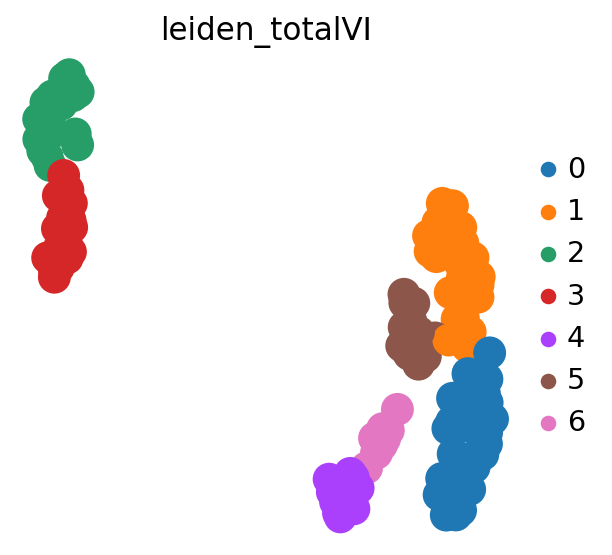

In [68]:
sc.pl.umap(
    adata,
    color=["leiden_totalVI"],
    frameon=False,
    ncols=1,
)